<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/MNIST_Latent_Space_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install packages

In [28]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.6 MB/s eta 0:00:00


# Import Libraries

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from umap import UMAP
from umap.plot import points
import umap

from tensorflow.keras.datasets import mnist

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

# Config

In [32]:
image_size = 28
sample_size = 1800

In [5]:
def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  x_test = x_test.astype('float32')
  x_test /= 255
  x_test = x_test * 2 - 1
  return x_train, y_train, x_test, y_test

In [6]:
X_train, y_train, X_test, y_test = get_mnist_data()

In [33]:
components = [100, 200, 300, 400, 500] + list(range(501, 600, 5)) + [600, 784]
flat_X_train = X_train[:sample_size].reshape(len(X_train[:sample_size]), -1)

# Helpers

In [8]:
def knn_classifier_evaluation(reduced_data, y_train):
  """
  Trains a KNN classifier on reduced data and outputs a classification report and confusion matrix.

  Args:
    reduced_data: The dimensionality-reduced data (e.g., output of repeated_umap).
    y_train: The training labels.
  """
  # Split data into training and testing sets for the KNN classifier
  X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
      reduced_data,
      y_train[:reduced_data.shape[0]],
      test_size=0.2,
      random_state=42
  )

  # Train a KNN classifier
  knn = KNeighborsClassifier(n_neighbors=5) # You can adjust n_neighbors
  knn.fit(X_train_knn, y_train_knn)

  # Make predictions
  y_pred_knn = knn.predict(X_test_knn)

  # Evaluate the model
  print("Classification Report:")
  print(classification_report(y_test_knn, y_pred_knn))

  print("\nConfusion Matrix:")
  print(sns.heatmap(confusion_matrix(y_test_knn, y_pred_knn)))

In [15]:
def method_performance_by_num_components(model_type, label:str):
  X_train_reduced_sets = []
  X_train_reconstructed_sets = []
  errors = []

  for component in components:
    if label == "KPCA":
      pca = model_type(n_components=component, fit_inverse_transform=True) # keep top k components that explain 95% for the variance
    else:
      pca = model_type(n_components=component) # keep top k components that explain 95% for the variance
    X_train_reduced = pca.fit_transform(flat_X_train) # data transformed via pca
    X_train_reduced_sets.append(X_train_reduced)
    X_train_reconstructed = pca.inverse_transform(X_train_reduced) # data attempted to be reconstructed
    X_train_reconstructed_sets.append(X_train_reconstructed)
    error = ((flat_X_train - X_train_reconstructed)**2).mean() # get the mean squared error
    errors.append(error)

  # get the index with the min error
  plt.plot(components, errors)
  plt.xlabel("Num Comp")
  plt.ylabel("Error")
  plt.title(f"{label} Num Component Comparison")
  plt.grid(True)
  plt.show()

# Dimensionality Reduction

## PCA

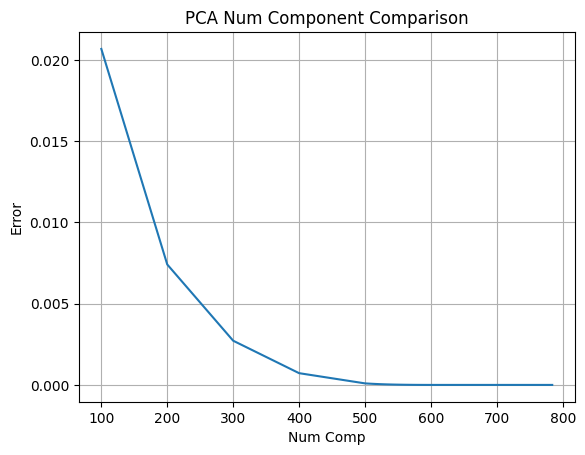

In [8]:
method_performance_by_num_components(PCA, label="PCA")

In [9]:
X_train.shape

(60000, 28, 28)

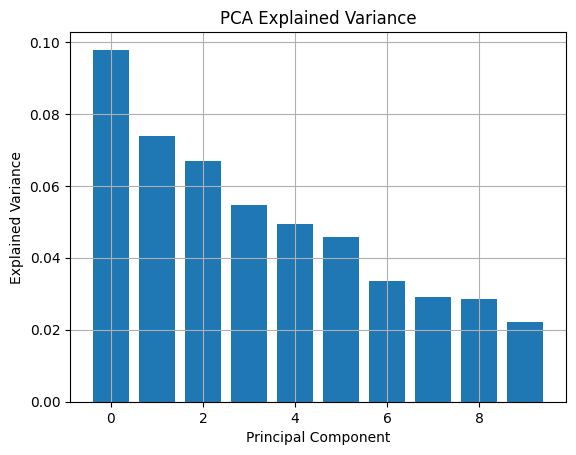

In [10]:
PCA_model = PCA(n_components=10).fit(flat_X_train)

explained_variance = PCA_model.explained_variance_ratio_
plt.bar(range(10), explained_variance)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

In [11]:
PCA_model = PCA(n_components=2).fit(flat_X_train)

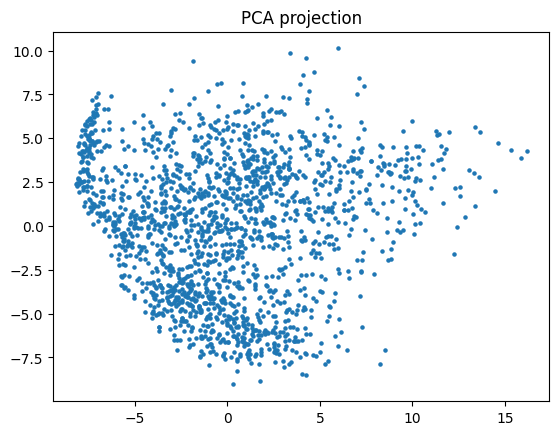

In [12]:
pca_embeddings = PCA_model.transform(flat_X_train)
pca_embeddings_df = pd.DataFrame(pca_embeddings, columns=['PCA1', 'PCA2'])

# Plot it (optional)
plt.scatter(pca_embeddings_df['PCA1'], pca_embeddings_df['PCA2'], s=5)
plt.title('PCA projection')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        33
           1       0.76      0.93      0.83        40
           2       0.39      0.32      0.35        41
           3       0.55      0.39      0.45        44
           4       0.33      0.41      0.37        41
           5       0.23      0.38      0.29        24
           6       0.40      0.39      0.39        31
           7       0.48      0.56      0.52        43
           8       0.38      0.23      0.29        26
           9       0.38      0.22      0.28        37

    accuracy                           0.46       360
   macro avg       0.45      0.45      0.44       360
weighted avg       0.46      0.46      0.45       360


Confusion Matrix:
Axes(0.125,0.11;0.62x0.77)


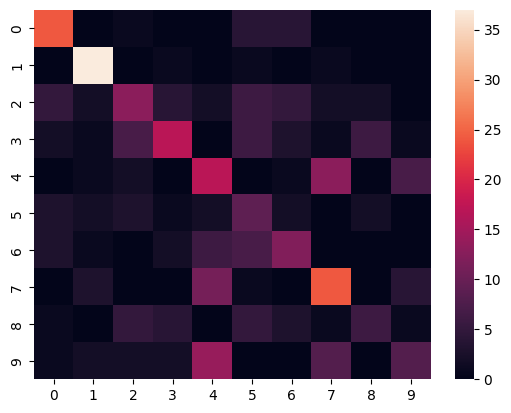

In [13]:
knn_classifier_evaluation(pca_embeddings, y_train)

## KPCA

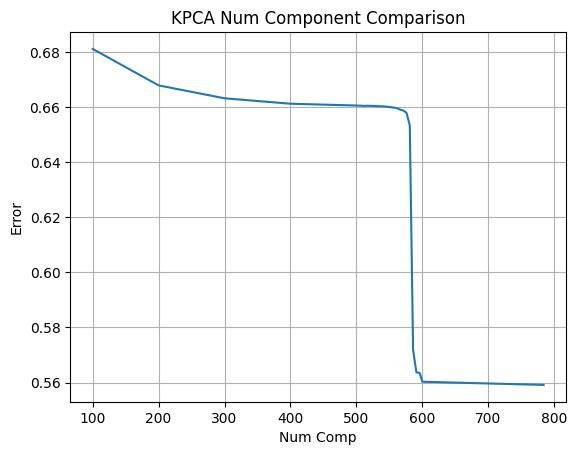

In [14]:
method_performance_by_num_components(KernelPCA, label="KPCA")

In [15]:
KPCA_model = KernelPCA(n_components=2, fit_inverse_transform=True).fit(flat_X_train)

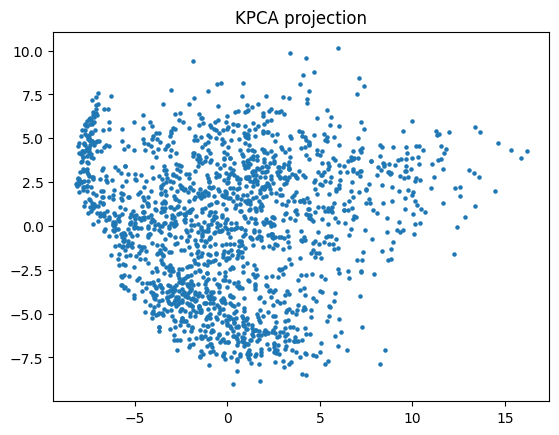

In [16]:
kpca_embeddings = KPCA_model.transform(flat_X_train)
kpca_embeddings_df = pd.DataFrame(kpca_embeddings, columns=['KPCA1', 'KPCA2'])

plt.scatter(kpca_embeddings_df['KPCA1'], kpca_embeddings_df['KPCA2'], s=5)
plt.title('KPCA projection')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        33
           1       0.76      0.93      0.83        40
           2       0.39      0.32      0.35        41
           3       0.55      0.39      0.45        44
           4       0.33      0.41      0.37        41
           5       0.23      0.38      0.29        24
           6       0.40      0.39      0.39        31
           7       0.48      0.56      0.52        43
           8       0.38      0.23      0.29        26
           9       0.38      0.22      0.28        37

    accuracy                           0.46       360
   macro avg       0.45      0.45      0.44       360
weighted avg       0.46      0.46      0.45       360


Confusion Matrix:
Axes(0.125,0.11;0.62x0.77)


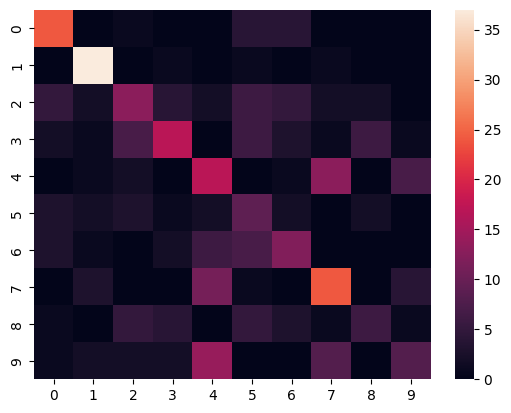

In [17]:
knn_classifier_evaluation(kpca_embeddings, y_train)

## UMAP

In [17]:
UMAP_model = UMAP(n_components=2, random_state=42).fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


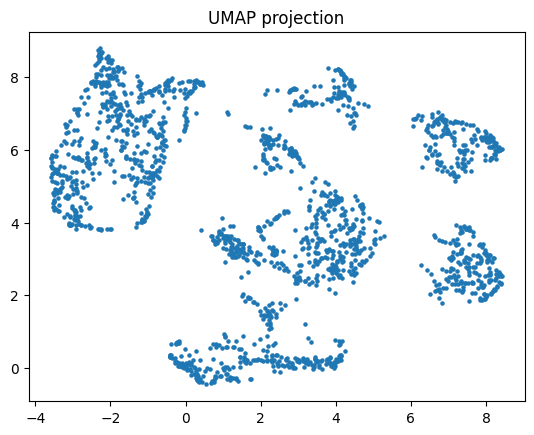

In [18]:
# Apply UMAP to reduce to 2 dimensions
umap_embeddings = UMAP_model.transform(flat_X_train)
umap_embeddings_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])

# Plot it (optional)
plt.scatter(umap_embeddings_df['UMAP1'], umap_embeddings_df['UMAP2'], s=5)
plt.title('UMAP projection')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        33
           1       0.91      0.97      0.94        40
           2       1.00      0.93      0.96        41
           3       0.91      0.91      0.91        44
           4       0.92      0.80      0.86        41
           5       0.79      0.79      0.79        24
           6       0.93      0.90      0.92        31
           7       0.90      0.84      0.87        43
           8       1.00      0.81      0.89        26
           9       0.70      0.95      0.80        37

    accuracy                           0.89       360
   macro avg       0.90      0.89      0.89       360
weighted avg       0.90      0.89      0.89       360


Confusion Matrix:
Axes(0.125,0.11;0.62x0.77)


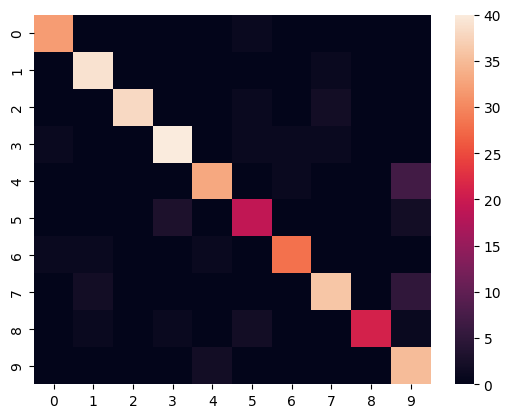

In [19]:
knn_classifier_evaluation(umap_embeddings, y_train)

## Repeated UMAP

In [20]:
def repeated_umap(X, n_components:int):
  UMAP_embeddings = UMAP(n_components=n_components, random_state=42).fit_transform(X)
  print(f"n_components: {n_components}")

  if n_components <= 2:
    plt.scatter(UMAP_embeddings[:, 0], UMAP_embeddings[:, 1], s=5)
    plt.title('UMAP projection')
    plt.show()
    return UMAP_embeddings

  else:
    return repeated_umap(
        UMAP_embeddings,
        n_components // 2 if n_components > 3 else 2
    )

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_components: 64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_components: 32


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_components: 16


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_components: 8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_components: 4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 489 with accuracies 
[2.43033214e-14 6.86527624e-07 2.21760982e-06 1.74055571e-06]
not reaching the requested tolerance 1.7434358596801758e-06.
Use iteration 409 instead with accuracy 
9.771618944598472e-07.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.38308342e-14 8.21990787e-07 6.03459529e-07 2.48319754e-06]
not reaching the requested tolerance 1.7434358596801758e-06.
  _, diffusion_map = lo

n_components: 2


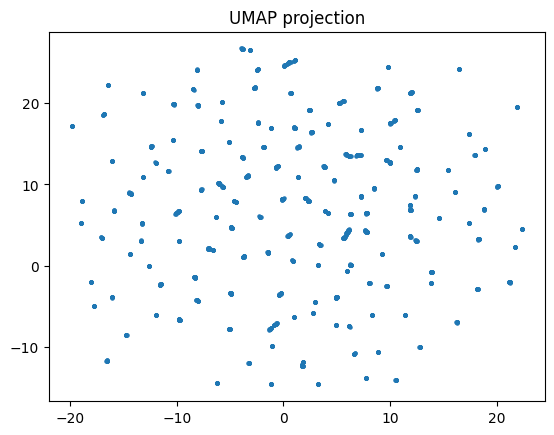

In [21]:
repeated_umap_embeddings = repeated_umap(flat_X_train, 64)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.89      1.00      0.94        40
           2       1.00      0.83      0.91        41
           3       0.92      0.80      0.85        44
           4       0.87      0.83      0.85        41
           5       0.63      0.79      0.70        24
           6       0.93      0.90      0.92        31
           7       0.84      0.86      0.85        43
           8       1.00      0.81      0.89        26
           9       0.76      0.95      0.84        37

    accuracy                           0.88       360
   macro avg       0.88      0.87      0.87       360
weighted avg       0.89      0.88      0.88       360


Confusion Matrix:
Axes(0.125,0.11;0.62x0.77)


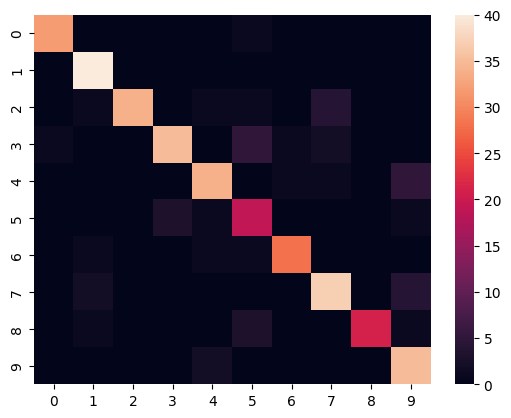

In [22]:
knn_classifier_evaluation(repeated_umap_embeddings, y_train)

## Variational autoencoder for further dimensionality reduction
Run autoencoder to get information into nicer 2d representation

# Preprocessing

(60000, 28, 28)


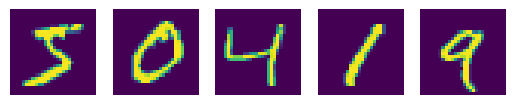

In [23]:
print(X_train.shape)
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

In [24]:
reduced_mnist = normalize(UMAP_model.transform(flat_X_train))
reduced_mnist_df = pd.DataFrame(reduced_mnist)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [25]:
reduced_mnist_df.head()

,0,1
0,0.713805,0.700344
1,0.749814,0.661649
2,-0.239480,0.970901
3,-0.389528,0.921014
4,-0.236197,0.971705


# Visualizations
Show samples from that latent space

[Code originally from here](https://umap-learn.readthedocs.io/en/latest/inverse_transform.html)

In [40]:
labels = y_train[:sample_size]

<Axes: >

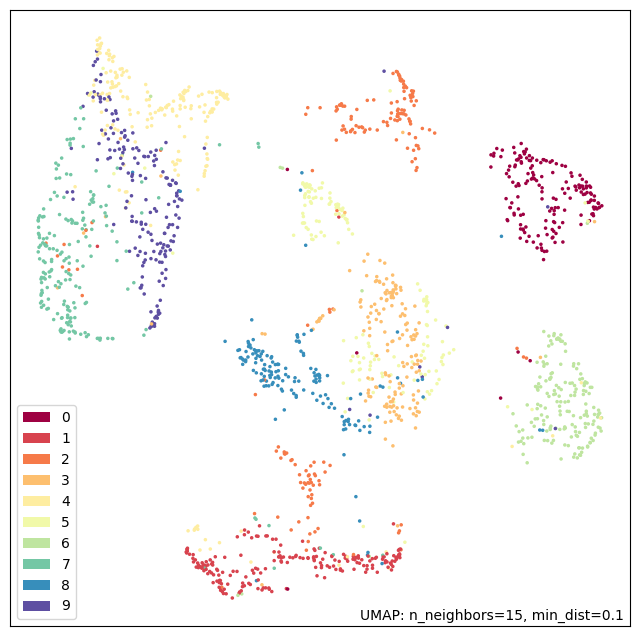

In [41]:
points(UMAP_model, labels=labels)

In [55]:
corners = np.array([
    [-1, 0],  # 1
    [-4, 8],  # 7
    [8, 1],  # 2
    [8, 7],  # 0
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

In [56]:
inv_transformed_points = UMAP_model.inverse_transform(test_pts)

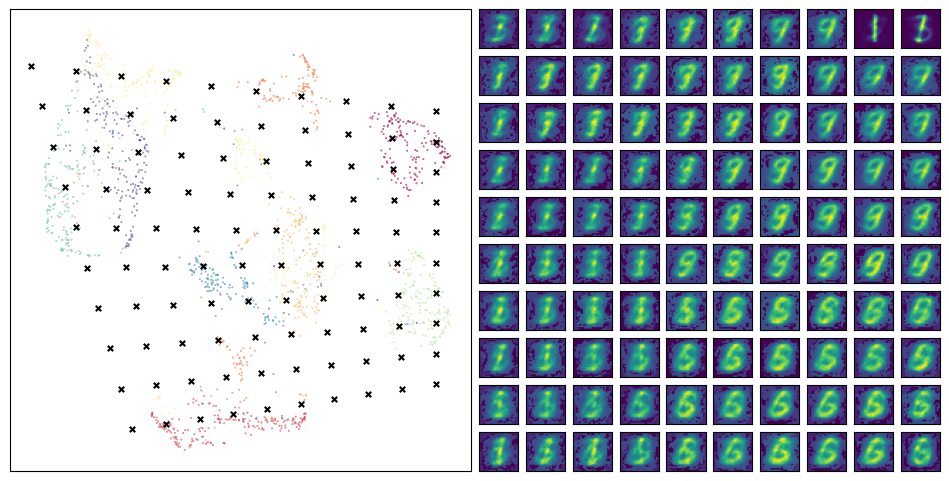

In [57]:
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(UMAP_model.embedding_[:, 0],
                   UMAP_model.embedding_[:, 1],
                   c=labels.astype(np.int32),
                   cmap='Spectral',
                   s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])